# Finite State Machine (FSM) Sandbox

## Imports

In [1]:
import sys
import time
import matplotlib.pyplot as plt
import cv2
import math

import delivery_driver as dd

sys.path.append("../../deliveryrobot")
from utilities.utilities import *
from sensors.camera.apriltagsensor import *
from sensors.calibration.camera_calibration import *
from navigation.slam.onlineslam import *
from navigation.astar.astar import *
from kinematics.movementai import *

## Robot Initialization

In [2]:
# Robot Instance initialization
start_time = time.time()

robot = dd.DeliveryRobot()

print(f"Robot initialization complete in {time.time()-start_time} seconds")

# Apriltag Sensor initialization
start_time = time.time()

sensor = AprilTagSensor(cal_dir)

print(f"Sensor calibration and initialization in {time.time()-start_time} seconds")

april_live = "live_april"

# SLAM Instance initialization
start_time = time.time()

slam = OnlineSLAM(3)
slam.debug = False

print(f"SLAM initialization in {time.time()-start_time} seconds")

# Astar Instance initialization
start_time = time.time()

scalar = 1
astar = Astar(
    beam_resolution=5,
    beam_range=np.pi/4,
    max_distance=0.2*scalar,
    heuristic_weight=1000/scalar,
    cost=1,
    fos=1,
    robot_radius_m=0.015*scalar
)
astar.debug = False
astar.verbose = False
robot_state = np.array([0.,0.,0.])


print(f"Astar initialization in {time.time()-start_time} seconds")

Robot initialization complete in 0.940298318862915 seconds
AprilTag sensor setup COMPLETE
Sensor calibration and initialization in 0.007676124572753906 seconds
SLAM initialization in 0.0007281303405761719 seconds
Astar initialization in 0.0010943412780761719 seconds


## Map Initialization

In [3]:
# sensor measurement
start_time = time.time()

april_img = robot.take_picture(image_dir + "/testing/pose_test/")
measurements={}
obstacles = {}
sensor.detect(april_img, measurements)

print(f"Sensor detections in {time.time()-start_time} seconds")
print(measurements)

# SLAM measurement
start_time = time.time()

slam.set_world_frame(int(measurements.keys()[1]))
slam.process_measurements(measurements)
slam.map_update(False)

print(f"SLAM estimation in {time.time()-start_time} seconds")
print(slam.map)

# Astar Path Planning
goal_id = "1"
goal_state = slam.map[goal_id]
goal_state[0] -= 0.4

start_time = time.time()

astar_test = astar.astar_move(robot_state, obstacles, goal_state)

print(f"Astar path planning in {time.time() - start_time} seconds; Results are:")
astar_test.print_info()

Sensor detections in 0.3326241970062256 seconds
{'1': [1.881920585329885, 0.05207535179247873, 0.024146858797704635], '4': [3.20190514892231, 1.4059597740591576, 1.0393137684711622], '5': [3.330341909580203, 1.4603378957511979, -0.07665277254109229], '6': [3.1742047749115345, 1.1039569833780158, -0.049723061326189075], '7': [3.0952739457677376, 1.0772689461692622, -0.12315493464599915]}
SLAM estimation in 0.017350435256958008 seconds
{'ROBOT': array([ 1.58579408e-16,  7.51420388e-16, -1.12251363e-16]), '1': [1.8819205853298857, 0.05207535179247854, 0.024146858797704673], '4': [3.2019051489223114, 1.405959774059159, 1.0393137684711624], '5': [3.3303419095802025, 1.4603378957511985, -0.07665277254109239], '6': [3.174204774911534, 1.1039569833780165, -0.04972306132618916], '7': [3.095273945767736, 1.077268946169263, -0.12315493464599922]}
01:37:17 - - - - - - UPCOMING PATH:
 - - - - - - - - - - - - - - -

	NODE: 0
                                    	LOC: [0. 0. 0.]

	NODE: 6
            

# Path Follow State

In [4]:
import matplotlib.pyplot as plt

def plot_estimations(x_dead_reckoning, y_dead_reckoning, psi_dead_reckoning,
                     x_slam, y_slam, psi_slam, time=None, bars=None):
    """
    Plots the x, y, and psi (orientation) estimations for dead reckoning and SLAM + sensors,
    with optional vertical bars.

    Parameters:
    x_dead_reckoning (list or np.ndarray): X positions from dead reckoning.
    y_dead_reckoning (list or np.ndarray): Y positions from dead reckoning.
    psi_dead_reckoning (list or np.ndarray): Psi (orientation) from dead reckoning.
    x_slam (list or np.ndarray): X positions from SLAM + sensors.
    y_slam (list or np.ndarray): Y positions from SLAM + sensors.
    psi_slam (list or np.ndarray): Psi (orientation) from SLAM + sensors.
    time (list or np.ndarray, optional): Time or sample indices. Defaults to indices of the arrays.
    bars (list or np.ndarray, optional): Binary array where 1s indicate positions to add vertical bars.

    Returns:
    None: The function directly shows the plots.
    """
    if time is None:
        time = range(len(x_dead_reckoning))  # Use index range if time is not provided
    
    if bars is None:
        bars = [0] * len(time)  # Default to no bars if not provided
        
    # Convert time to seconds if it’s not already in a suitable unit
    time = np.array(time)
    time = time - time[0]  # Normalize to start from 0
    
    # Optional: Convert time to milliseconds or seconds if too small
    time = time * 1e6  # For example, converting from microseconds to seconds
    
    # Create the subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))

    # Plot x
    axs[0].plot(time, x_dead_reckoning, label='Dead Reckoning', marker='o')
    axs[0].plot(time, x_slam, label='SLAM + Sensors', marker='x')
    axs[0].set_title('X Position Comparison')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('X Position')
    axs[0].legend()

    # Plot y
    axs[1].plot(time, y_dead_reckoning, label='Dead Reckoning', marker='o')
    axs[1].plot(time, y_slam, label='SLAM + Sensors', marker='x')
    axs[1].set_title('Y Position Comparison')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Y Position')
    axs[1].legend()

    # Plot psi (orientation)
    axs[2].plot(time, psi_dead_reckoning, label='Dead Reckoning', marker='o')
    axs[2].plot(time, psi_slam, label='SLAM + Sensors', marker='x')
    axs[2].set_title('Psi (Orientation) Comparison')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Psi (Orientation)')
    axs[2].legend()

    # Add vertical bars
    for i, t in enumerate(time):
        if bars[i] == 1:
            axs[0].axvline(x=t, color='red', linestyle='--', linewidth=1)
            axs[1].axvline(x=t, color='red', linestyle='--', linewidth=1)
            axs[2].axvline(x=t, color='red', linestyle='--', linewidth=1)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

[<kinematics.movementai.SteeringOutput object at 0x7ef224f7b8>, 0.0, 0.0, 0.0]
1724722637.5642552 steering [0.01 0.  ] 0.0

------------ TIME STEP 0 -------------

translation_m = 0.0 | delta_theta = 0.0
[<kinematics.movementai.SteeringOutput object at 0x7ef224f5f8>, 0.008747577667236328, 0.0, 0.0]
1724722637.6179843 steering [0.01 0.  ] 0.0

Path Follow Time: 0.0393373966217041
Robot State = [0.01180923 0.        ]
Goal State = [0.4 0. ]
SLAM Map: {'ROBOT': array([ 1.58579408e-16,  7.51420388e-16, -1.12251363e-16]), '1': [1.4819205853298856, 0.05207535179247854, 0.024146858797704673], '4': [3.2019051489223114, 1.405959774059159, 1.0393137684711624], '5': [3.3303419095802025, 1.4603378957511985, -0.07665277254109239], '6': [3.174204774911534, 1.1039569833780165, -0.04972306132618916], '7': [3.095273945767736, 1.077268946169263, -0.12315493464599922]}


------------ TIME STEP 1 -------------

translation_m = 0.008747577667236328 | delta_theta = 0.0
[<kinematics.movementai.SteeringOutput

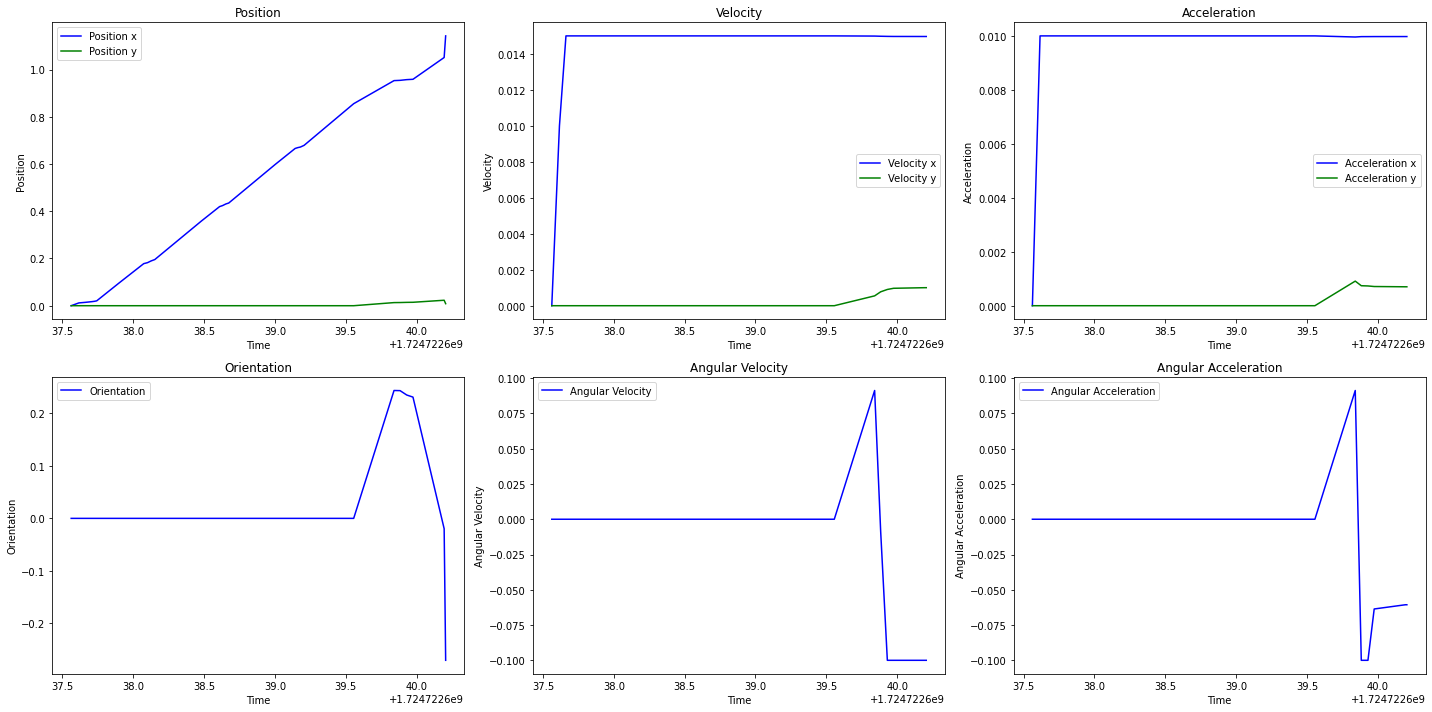

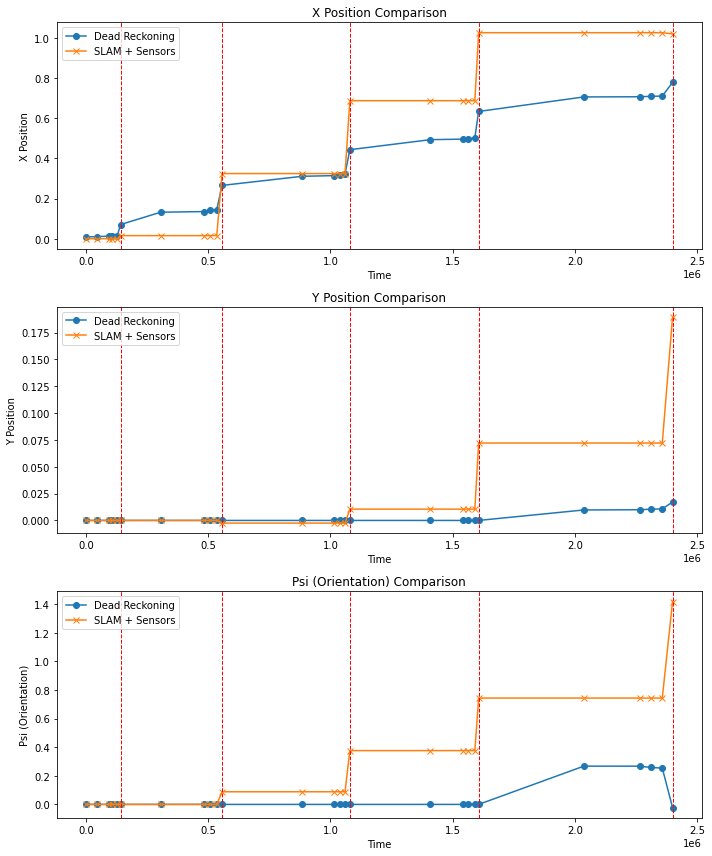

In [5]:
goal_time = 1
call_time = 0
total_time = 0
start_time = time.time()
start_time_abs = time.time()
n = -1
t = 0
thresh = 2

x_dr = []
y_dr = []
psi_dr = []
x_slam = []
y_slam = []
psi_slam = []
sensor_run = []
time_values = []

translation_m_sum = 0
delta_theta_sum = 0

x_dr_t = 0
y_dr_t = 0
psi_dr_t = 0

# setup path and target
robot.update_path_ai(astar_test.path)

# false if within parking range
output, delta_x, delta_y, delta_theta = robot.path_follow_ai(goal_time, call_time)

while output:
    
    print(f"\n------------ TIME STEP {t} -------------\n")
    
    # set a new start time
    loop_start_time = time.time()
    
    # Record the elapsed time since the start of the loop
    elapsed_time = loop_start_time - start_time_abs
    time_values.append(elapsed_time)
    
    # determine translation magnitude
    translation_m = math.sqrt(delta_x ** 2 + delta_y ** 2)
    translation_m_sum += translation_m
    delta_theta_sum += delta_theta
    print(f"translation_m = {translation_m} | delta_theta = {delta_theta}")
    
    if n == 4: sensor_run.append(1)
    else: sensor_run.append(0)
    
    if n == 4:
        
        # AprilSensor
        sensor_time = time.time()
        april_img = robot.take_picture(image_dir + "/testing/pose_test/")
        sensor.detect(april_img, measurements)
        
        print()
        print(f"AprilSensor in {time.time() - sensor_time} seconds")
        print(f"Sensor Measurements: {measurements}")
        print()
        
        # SLAM measurement update
        slam_time = time.time()
        slam.process_measurements(measurements)
        slam.process_movement(translation_m_sum, delta_theta_sum)
        slam.map_update(motion=True)
        
        translation_m_sum = 0
        delta_theta_sum = 0
        
        print()
        print(f"SLAM Full Update in {time.time() - slam_time} seconds")
        print()
    
    elif n == 5:
        
        # Astar map update
        astar_time = time.time()
        goal_state = slam.map[goal_id]
        goal_state[0] -= 0.4
        print(robot_state, obstacles, goal_state)
        astar_test = astar.astar_move(robot_state, obstacles, goal_state)
        #robot.update_path_ai(astar_test.path)
        
        print()
        print(f"Astar in {time.time() - astar_time} seconds")
        print()
        
        n = 0
        
    """# include movement update if translation and rotation
    if translation_m > 0 or delta_theta > 0:
        slam_time = time.time()
        
        slam.process_movement(translation_m, delta_theta)
        slam.map_update(motion=True)
        
        print()
        print(f"SLAM Move Update in {time.time() - slam_time} seconds")
        print()
    
        # Compare Dead Reckoning to SLAM
        print()
        print(f"Dead Reck State: {robot.robot_ai.position} {robot.robot_ai.orientation_rad}")
        print()
        
        # Update robot and target locations
        dreck_time = time.time()
        #robot.robot_ai.slam_update(slam.map["ROBOT"])

        print()
        print(f"Dead Reck Update in {time.time() - dreck_time} seconds")
        print()"""
    
    # check if stalling
    if total_time > 4:
        robot.robot.stop()
        break
             
    # get time since last call
    call_time = time.time() - start_time
    total_time += call_time
    
    pf_time = time.time()
    output, delta_x, delta_y, delta_theta = robot.path_follow_ai(goal_time, call_time)
    
    # set a new start time
    start_time = time.time()
    
    print()
    print(f"Path Follow Time: {time.time() - pf_time}")
    print(f"Robot State = {robot.robot_ai.position}")
    print(f"Goal State = {robot.target_ai.position}")
    print(f"SLAM Map: {slam.map}")
    print()
    
    # update arrays
    x_dr_t += delta_x
    y_dr_t += delta_y
    psi_dr_t += delta_theta
    x_slam_t, y_slam_t, psi_slam_t = slam.map["ROBOT"]
    
    x_dr.append(x_dr_t)
    y_dr.append(y_dr_t)
    psi_dr.append(psi_dr_t)
    x_slam.append(x_slam_t)
    y_slam.append(y_slam_t)
    psi_slam.append(psi_slam_t)
    
    n += 1
    t += 1

arrive_time = 0
    
while robot.arrive_ai(goal_time, call_time):
    
    # set a new start time
    start_time = time.time()
    
    if t > 25:
        robot.robot.stop()
        break
        
    t += 1
    
    # get time since last call
    call_time = time.time() - start_time
    total_time += call_time

robot.robot.stop()
robot.robot_ai.kplot.plot_data()

if time_values:
    time_values = np.array(time_values) - time_values[0]
plot_estimations(x_dr, y_dr, psi_dr, x_slam, y_slam, psi_slam, time=time_values, bars=sensor_run)

In [6]:
robot.stop()

In [7]:
"""robot.update_path_ai(astar_test.path)

# setup time variables
goal_time = 1
call_time = 0
total_time = 0
start_time = time.time()
last_call = time.time()
n = 0
m = 0
thresh = 2

while robot.path_follow_ai(goal_time, call_time):
    
    # get time it took to make the call
    last_call = time.time()
    call_time = last_call - start_time
    total_time+=call_time
    
    # set a new start time
    start_time = time.time()
    
    if n > 5:
        if m > thresh:
            time.sleep(0.45)
            print("long pause")
            m = 0
            thresh += 1
        print("pause")
        time.sleep(0.25)
        n = 0
        m += 1
    else:
        n += 1
    
    
    if total_time > 4:
        robot.robot.stop()
        
        break

robot.target_ai.slam_update(goal_state)
print(f"targeting {goal_state} from {robot.robot_ai.position}")

while robot.arrive_ai(goal_time, call_time):
    
    # get time it took to make the call
    last_call = time.time()
    call_time = last_call - start_time
    total_time+=call_time
    
    # set a new start time
    start_time = time.time()
    
    if total_time > 4:
        robot.robot.stop()
        break

robot.robot.stop()
robot.robot_ai.kplot.plot_data()"""

'robot.update_path_ai(astar_test.path)\n\n# setup time variables\ngoal_time = 1\ncall_time = 0\ntotal_time = 0\nstart_time = time.time()\nlast_call = time.time()\nn = 0\nm = 0\nthresh = 2\n\nwhile robot.path_follow_ai(goal_time, call_time):\n    \n    # get time it took to make the call\n    last_call = time.time()\n    call_time = last_call - start_time\n    total_time+=call_time\n    \n    # set a new start time\n    start_time = time.time()\n    \n    if n > 5:\n        if m > thresh:\n            time.sleep(0.45)\n            print("long pause")\n            m = 0\n            thresh += 1\n        print("pause")\n        time.sleep(0.25)\n        n = 0\n        m += 1\n    else:\n        n += 1\n    \n    \n    if total_time > 4:\n        robot.robot.stop()\n        \n        break\n\nrobot.target_ai.slam_update(goal_state)\nprint(f"targeting {goal_state} from {robot.robot_ai.position}")\n\nwhile robot.arrive_ai(goal_time, call_time):\n    \n    # get time it took to make the call\

###### 